In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [2]:
df=pd.read_csv('product j.csv', parse_dates=['Month-Year'])


In [3]:
sales_j= df.drop(['Product Name','Product Category','Month','Year','Month No.'],axis=1)

In [4]:
sales_j = sales_j.rename(columns={'Month-Year': 'ds',
                        'Sales': 'y'})

sales_j.head(5)

,ds,y,Market Size,Marketing Expense
0,2019-01-01,63722,238469,164221
1,2019-02-01,76987,288111,198407
2,2019-03-01,99645,372905,256800
3,2019-04-01,68529,256458,176610
4,2019-05-01,45119,168850,116279


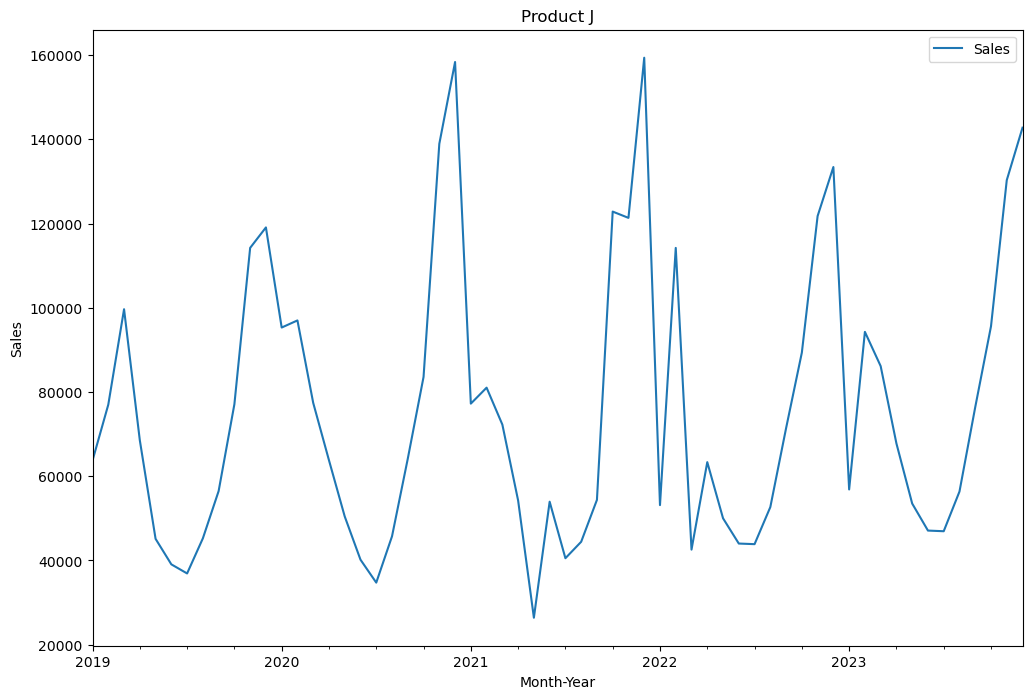

In [5]:
ax = sales_j.set_index('ds')['y'].plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Month-Year')
plt.title('Product J')
plt.legend(['Sales'])
plt.show()


In [6]:
train= sales_j[:48]
test=sales_j[48:]

In [7]:
changepoint_prior_scale_range = [0.001, 0.01, 0.1,0.2, 0.3, 0.5]
seasonality_prior_scale_range = [0.01, 0.1, 1.0, 3.0, 5.0, 10.0]
seasonality_mode_range = ['additive', 'multiplicative']

param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale_range,
    'seasonality_prior_scale': seasonality_prior_scale_range,
    'seasonality_mode' : seasonality_mode_range
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    m.add_regressor('Market Size')
    m.add_regressor('Marketing Expense')
    m.fit(train)
    df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

15:41:36 - cmdstanpy - INFO - Chain [1] start processing
15:41:36 - cmdstanpy - INFO - Chain [1] done processing
15:41:39 - cmdstanpy - INFO - Chain [1] start processing
15:41:40 - cmdstanpy - INFO - Chain [1] done processing
15:41:43 - cmdstanpy - INFO - Chain [1] start processing
15:41:43 - cmdstanpy - INFO - Chain [1] done processing
15:41:47 - cmdstanpy - INFO - Chain [1] start processing
15:41:47 - cmdstanpy - INFO - Chain [1] done processing
15:41:51 - cmdstanpy - INFO - Chain [1] start processing
15:41:51 - cmdstanpy - INFO - Chain [1] done processing
15:41:55 - cmdstanpy - INFO - Chain [1] start processing
15:41:56 - cmdstanpy - INFO - Chain [1] done processing
15:41:59 - cmdstanpy - INFO - Chain [1] start processing
15:42:01 - cmdstanpy - INFO - Chain [1] done processing
15:42:06 - cmdstanpy - INFO - Chain [1] start processing
15:42:06 - cmdstanpy - INFO - Chain [1] done processing
15:42:11 - cmdstanpy - INFO - Chain [1] start processing
15:42:11 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
..                      ...                      ...              ...   
67                    0.500                     3.00   multiplicative   
68                    0.500                     5.00         additive   
69                    0.500                     5.00   multiplicative   
70                    0.500                    10.00         additive   
71                    0.500                    10.00   multiplicative   

            rmse  
0   22114.500085  
1   24371.923441  
2   23875.991715  
3   24272.258220  
4   22441.838991  
..       

In [8]:
tuning_results.sort_values('rmse',ascending=True)

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,rmse
28,0.1,1.00,additive,21902.747646
32,0.1,5.00,additive,21923.878399
24,0.1,0.01,additive,21958.103325
48,0.3,0.01,additive,22024.741805
60,0.5,0.01,additive,22046.397157
...,...,...,...,...
51,0.3,0.10,multiplicative,32174.570912
63,0.5,0.10,multiplicative,32234.188938
50,0.3,0.10,additive,33424.024207
38,0.2,0.10,additive,36111.319069


In [9]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 3.0, 'seasonality_mode': 'additive'}


In [9]:
# Create a Prophet model
#model = Prophet(changepoint_prior_scale=0.0100, seasonality_prior_scale=4.006, interval_width=0.95)
model = Prophet(changepoint_prior_scale=0.1, seasonality_prior_scale=1.00, seasonality_mode= 'additive',interval_width=0.95)
model.add_regressor('Market Size')
model.add_regressor('Marketing Expense')

In [10]:
model.fit(train)

16:08:57 - cmdstanpy - INFO - Chain [1] start processing
16:08:57 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
# Create a DataFrame for future dates (including 2023)
future_dates = model.make_future_dataframe(periods=len(test), freq='MS')  # 12 months in 2023

In [12]:
future_dates['Market Size'] = sales_j['Market Size']
future_dates['Marketing Expense'] = sales_j['Marketing Expense']

In [13]:
future_dates

,ds,Market Size,Marketing Expense
0,2019-01-01,238469,164221
1,2019-02-01,288111,198407
2,2019-03-01,372905,256800
3,2019-04-01,256458,176610
4,2019-05-01,168850,116279
5,2019-06-01,146172,100661
6,2019-07-01,138085,95092
7,2019-08-01,169281,116575
8,2019-09-01,211288,145504
9,2019-10-01,427430,294350


In [14]:
# Make predictions for the future
forecast = model.predict(future_dates)

In [15]:
forecasted_df=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

In [16]:
forecasted_df

,ds,yhat,yhat_lower,yhat_upper
48,2023-01-01,78725.694524,63933.238761,93649.927908
49,2023-02-01,115309.691812,101028.425052,128629.888385
50,2023-03-01,97589.447894,83422.558046,113449.108348
51,2023-04-01,80193.355772,64937.617663,95694.738545
52,2023-05-01,62795.173937,46697.413822,79023.653168
53,2023-06-01,57837.767135,42327.674867,71983.793589
54,2023-07-01,58286.892156,43081.879236,73866.361760
55,2023-08-01,69185.462150,54330.446804,83046.332495
56,2023-09-01,90508.002877,76559.189088,104480.593651
57,2023-10-01,121681.130183,106613.727856,136494.616430


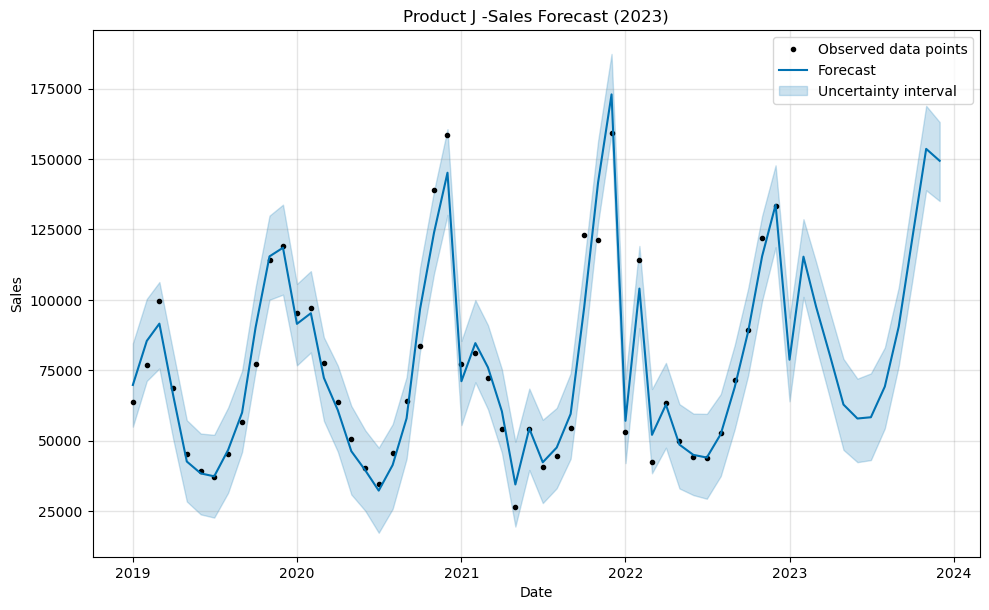

In [17]:
fig = model.plot(forecast, include_legend=True, uncertainty=True)
plt.title('Product J -Sales Forecast (2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

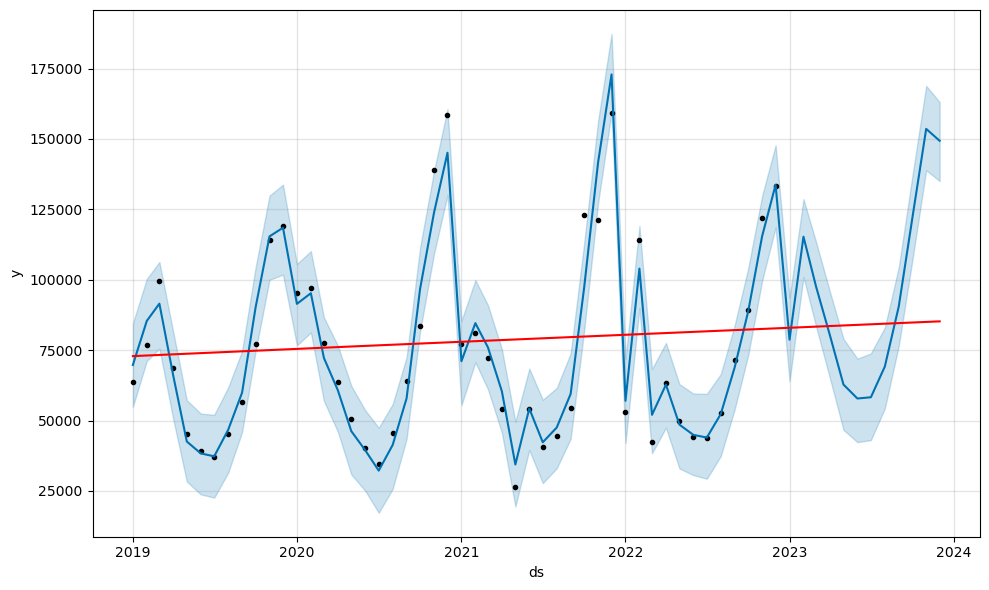

In [18]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

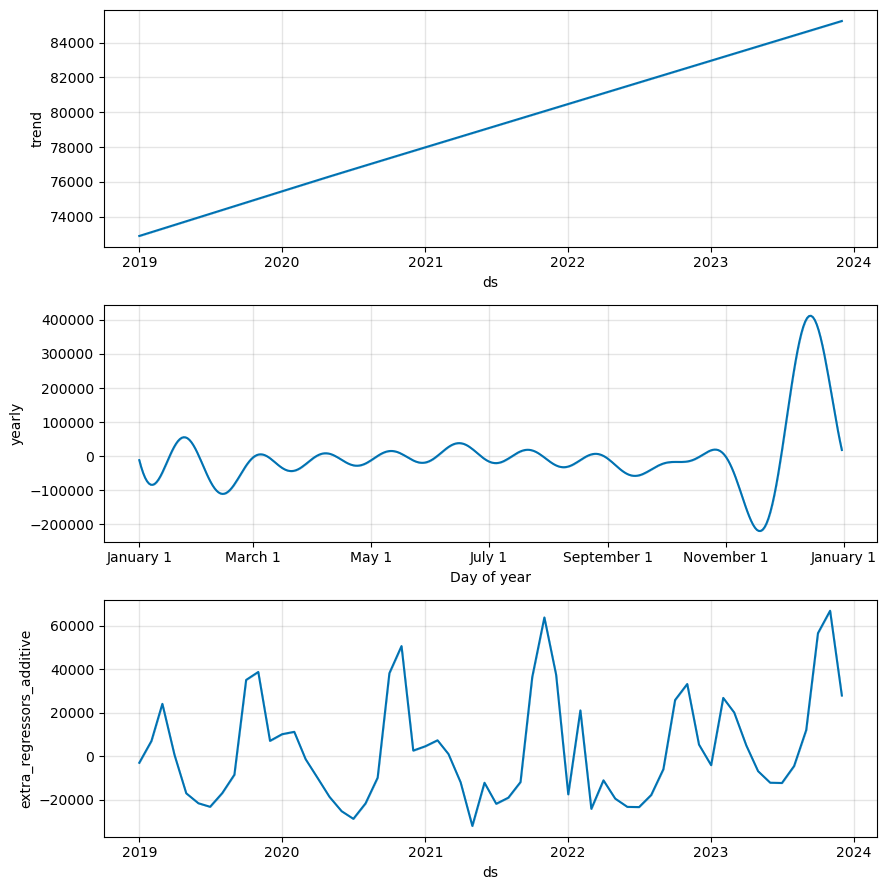

In [19]:
fig2 = model.plot_components(forecast)

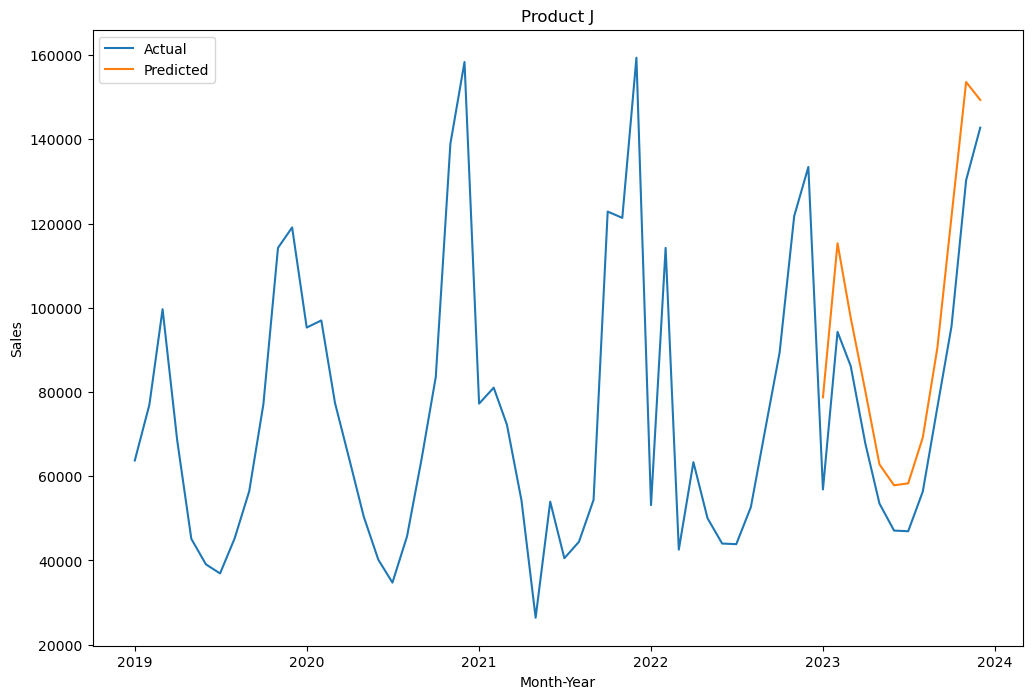

In [20]:
# Reset index of sales_b DataFrame
sales_j_reset_index = sales_j.reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(sales_j_reset_index['ds'], sales_j_reset_index['y'], label='Actual')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Predicted')
plt.title('Product J')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [21]:
#model evaluation

In [22]:
pred=forecasted_df['yhat']
test_df=test['y']

In [23]:
mae_fb= mean_absolute_error(test_df,pred)
mse_fb=mean_squared_error(test_df, pred)
mape_fb= mean_absolute_percentage_error(test_df,pred)
rmse_fb= np.sqrt(mean_squared_error(test_df,pred))


print(f'MAE - FB PROPHET: {mae_fb:.3f}')
print(f'MAPE - FB PROPHET: {mape_fb:.3f}')
print(f'MSE - FB PROPHET: {mse_fb:.3f}')
print(f'RMSE - FB PROPHET: {rmse_fb:.3f}')

MAE - FB PROPHET: 15095.570
MAPE - FB PROPHET: 0.207
MSE - FB PROPHET: 264092516.920
RMSE - FB PROPHET: 16250.924


In [25]:
#Set initial window to 2 years (24 months), period to 1 year (12 months), and horizon to 1 year (12 months)
df_cv = cross_validation(model, initial='730 days', period='365 days', horizon='365 days', parallel="processes")

In [26]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,31 days,3.329512e+06,1824.695126,1824.695126,0.034347,0.034347,0.034947,1.0
1,62 days,1.654886e+09,40680.290407,40680.290407,0.356192,0.356192,0.433374,0.0
2,90 days,1.112223e+08,10546.198687,10546.198687,0.247802,0.247802,0.220484,1.0
3,121 days,2.031579e+08,14253.348264,14253.348264,0.225054,0.225054,0.253590,1.0
4,151 days,2.144112e+08,14642.787733,14642.787733,0.292856,0.292856,0.343094,0.0
5,182 days,7.846983e+07,8858.319849,8858.319849,0.201325,0.201325,0.223860,1.0
6,212 days,1.151956e+08,10732.920074,10732.920074,0.244742,0.244742,0.278867,1.0
7,243 days,1.726394e+08,13139.232107,13139.232107,0.249501,0.249501,0.285063,1.0
8,274 days,4.235444e+08,20580.194089,20580.194089,0.288254,0.288254,0.336796,0.0
9,304 days,6.544521e+08,25582.261802,25582.261802,0.286338,0.286338,0.334182,0.0


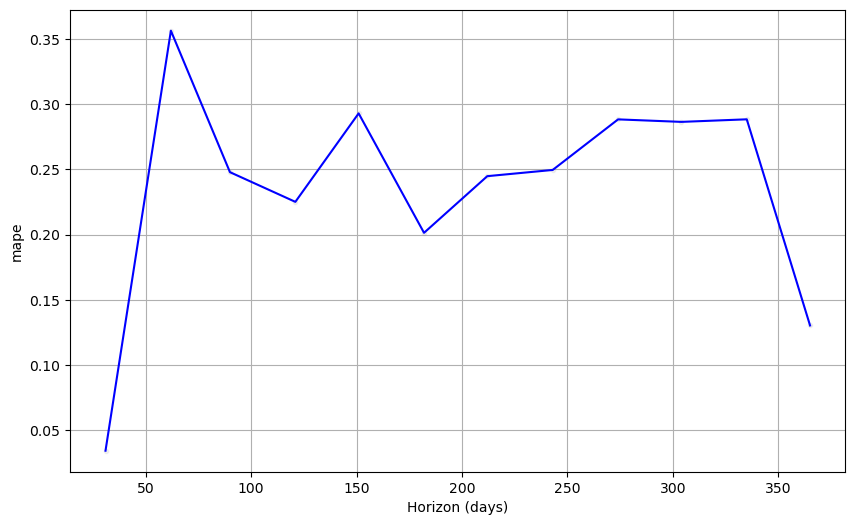

In [27]:
fig = plot_cross_validation_metric(df_cv, metric='mape')